# Monte Carlo Simulation for Portfolio Risk

This notebook aims to give readers an understanding of how Monte Carlo methods can be used to model portfolio risk in a probabilistic and forward-looking manner. Rather than relying on single-point estimates or static risk measures, Monte Carlo simulation allows us to generate a distribution of possible future portfolio outcomes based on historical return characteristics and explicit statistical assumptions.

By simulating thousands of potential price paths, we can quantify downside risk, tail behaviour, and path-dependent effects such as drawdowns, providing a more realistic picture of portfolio risk under both normal and stressed market conditions.

### Background

In financial markets, future returns are inherently uncertain and cannot be forecasted with certainty. Traditional risk metrics such as volatility or beta summarise risk using historical averages, but they fail to capture the full range of possible outcomes and the asymmetry often observed in real-world returns.

Monte Carlo simulation addresses this limitation by:
- Modelling asset returns as random variables drawn from an assumed distribution (e.g. multivariate normal or Student-t)
- Preserving empirical volatility and correlation structures across assets
- Generating many alternative future scenarios rather than a single forecast

This framework is particularly useful for portfolio risk analysis, as it allows us to:
- Incorporate cross-asset dependencies
- Examine tail risk and extreme outcomes
- Evaluate the likelihood of breaching loss thresholds
- Stress-test portfolios under adverse volatility and correlation regimes

---

### Sections of the notebook

1. **Data Preparation**
   - Load historical price data for multiple assets
   - Compute log returns
   - Estimate empirical means, volatilities, and the covariance matrix

2. **Monte Carlo Simulation Engine**
   - Generate uncorrelated random shocks
   - Apply Cholesky decomposition to introduce realistic cross-asset correlation
   - Simulate correlated daily return paths
   - Aggregate asset-level returns into portfolio-level returns using predefined weights

3. **Portfolio Value Path Construction**
   - Apply compounding to convert returns into portfolio value trajectories
   - Simulate thousands of portfolio paths over the chosen time horizon

4. **Risk Metrics and Analysis**
   - Compute Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)
   - Analyse maximum drawdowns and loss distributions
   - Estimate the probability of breaching predefined loss thresholds

5. **Stress Testing and Scenario Analysis**
   - Shock volatility and correlation assumptions to mimic crisis regimes
   - Compare baseline and stressed portfolio risk profiles
   - Interpret changes in tail risk and downside exposure




**Import the libraries**

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import numpy as np
import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. **Data Preparation**

We will be loading our data for the following tickers: ```['BNS.TO', 'GOOGL', 'XOM', 'NIO', 'KO', 'PEP','ARCC','IBM','AGNC','LCID']``` from **YahooFinance**. For our period of analysis, we will be using data from **2022** to **2024**

**Parameter Initialisation**

In [8]:
tickers = ['BNS.TO', 'GOOGL', 'XOM', 'NIO', 'KO', 'PEP','ARCC','IBM','AGNC','LCID']
start_date = '2022-01-01'
end_date = '2024-12-31'

In [9]:
# Define a function to import the data from Yahoo Finance
def import_historical_data(ticker, start_date, end_date):
  """
  This function takes in a list of stock tickers and a date range,
  and returns a DataFrame containing the adjusted closing prices for each ticker
  over the specified date range.
  """
  historical_data = pd.DataFrame()
  data = yf.download(ticker, start=start_date, end=end_date)
  if historical_data.empty:
    # Set the index to the date column of our first data
    historical_data.index = data.index
  
  # New section to handle for NaN values
  # Fill Nan values with the previous day's closing price
  data['Close'] = data['Close'].ffill()
  # If there are still NaN values (e.g., at the start), fill them with the next day's closing price
  data['Close'] = data['Close'].bfill()
  historical_data[ticker] = data['Close']
  return historical_data

In [10]:
tickers_prices = import_historical_data(tickers, start_date, end_date)
tickers_prices

[*********************100%***********************]  10 of 10 completed


,BNS.TO,GOOGL,XOM,NIO,KO,PEP,ARCC,IBM,AGNC,LCID
Date,,,,,,,,,,
2022-01-03,8.686453,14.355343,71.785858,143.904205,116.169739,52.627060,409.299988,33.470001,152.591614,55.125240
2022-01-04,8.748298,14.505664,71.785858,143.316635,117.860542,53.505657,394.100006,31.580000,152.812164,57.198727
2022-01-05,8.523405,14.293851,71.295975,136.741821,118.031342,53.949387,366.799988,29.879999,153.332626,57.910126
2022-01-06,8.545894,14.307515,72.101944,136.714523,115.572006,53.665394,382.200012,29.309999,153.367889,59.272209
2022-01-07,8.602118,14.498832,72.291573,135.989487,115.136490,53.541161,419.799988,29.299999,153.561981,59.758030
...,...,...,...,...,...,...,...,...,...,...
2024-12-23,8.046865,19.687325,72.074356,193.870712,216.340286,60.592327,31.000000,4.480000,145.476547,102.536766
2024-12-24,8.063896,19.888494,72.027603,195.344955,218.757843,61.039143,32.000000,4.620000,146.938141,102.633217
2024-12-26,7.987258,20.062235,72.027603,194.836945,219.225754,60.776878,33.000000,4.690000,146.582367,102.720039


Estimate and compute the mean, volatility and covariance

In [11]:
pct_return = tickers_prices.pct_change().dropna() # Daily percentage return
volatility = pct_return.std() # Volatility
mean_return = pct_return.mean() # Mean return
cov_matrix = pct_return.cov() # Covariance matrix

Weighting the stocks in our portfolio. For now, we will be randomly generating our weights for each stock and holding it constant across the entire duration of analysis

In [12]:
weights = np.random.random(len(mean_return))
weights /= np.sum(weights) # Normalize the weights
assert(sum(weights) == 1)

### 2 and 3. **Monte Carlo Simulation Engine, Portfolio Value Path Construction**


We will generate uncorrelated random shocks and apply the Cholesky decomposition to introduce realistic cross-asset correlation. Simulate correlated daily return paths, and finally aggregating asset-level returns into portfolio-level returns using predefined weights

Finally, we will apply compounding to convert returns into portfolio value trajectories, and simulate the projection with thousands of portfolio paths over the chosen time horizon

In [13]:
def monte_carlo_simulation(num_simulation, num_trading_days, weights, mean_returns, cov_matrix, initial_investment):
  meanM = np.full(shape = (num_trading_days, len(weights)), fill_value = mean_returns)
  meanM = meanM.T
  
  portfolio_sims = np.full(shape=(num_trading_days, num_simulation), fill_value=0.0)
  
  for sim in range(num_simulation):
    Z = np.random.normal(size=(num_trading_days, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,sim] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_investment
    
  return portfolio_sims


def visualise_simulation(portfolio_sims):
  font = {'family': 'serif',
    'color':  'white',
    'weight': 'normal',
    'size': 25,
    }
  plt.figure(figsize=(21, 8))
  plt.plot(portfolio_sims)
  plt.ylabel('Portfolio Value ($)',  fontdict=font)
  plt.xlabel('Days',  fontdict=font)
  plt.title('Monte carlo simulation of a stock portfolio',  fontdict=font)
  plt.show()

In [14]:
num_simulation = 10000
num_trading_days = 252
initial_investment = 1000000

portfolio_simulations = monte_carlo_simulation(num_simulation, num_trading_days, weights, mean_return, cov_matrix, initial_investment)

Visualising our Monte-Carlo Simulation

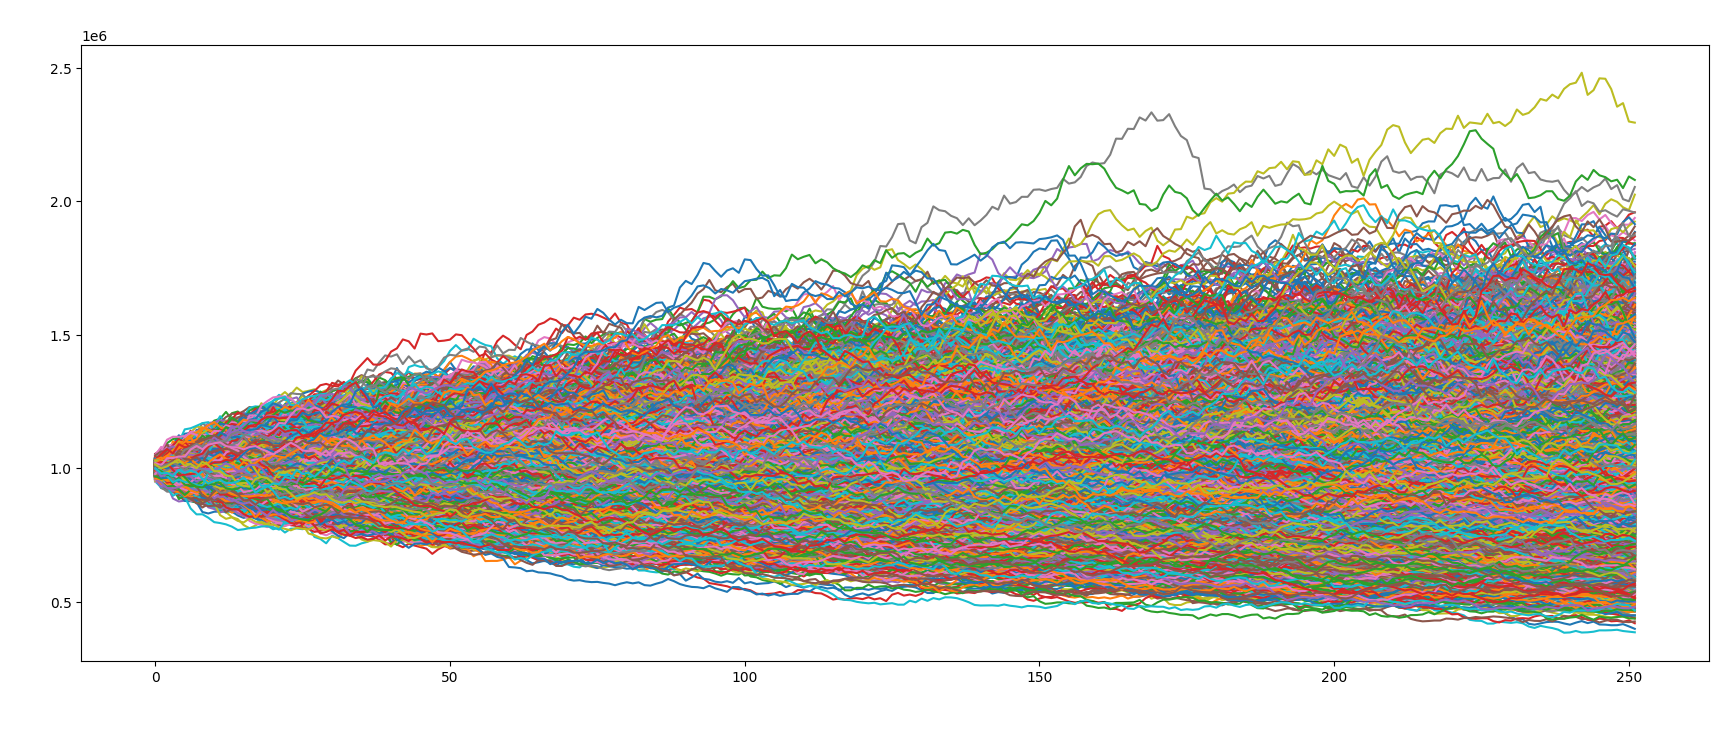

In [15]:
visualise_simulation(portfolio_simulations)

From our simulation, we can see that as we project our timeline further into the future, the dispersion of portfolio value paths increases markedly. This widening spread reflects the compounding nature of uncertainty: small variations in returns at earlier periods are amplified over time, leading to increasingly divergent outcomes across simulation paths.

One interesting observation from the simulation is that we can roughly define upper and lower bounds for the portfolio’s potential value at each future horizon. These bounds are not deterministic limits, but probabilistic envelopes derived from the distribution of simulated outcomes (for example, percentile bands). The upper bound represents optimistic but plausible scenarios driven by sustained positive return realizations, while the lower bound captures adverse scenarios in which negative shocks and drawdowns compound over time.

As the time horizon extends, these bounds move further apart, highlighting the trade-off between return potential and risk. While longer investment horizons increase the probability of achieving higher absolute returns, they also expose the portfolio to a wider range of unfavorable outcomes. This reinforces the importance of risk management measures such as diversification, position sizing, and drawdown control, particularly when making long-term allocation decisions.

### 4. **Risk Metrics and Analysis**

Now, we will compute Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR), and analyse maximum drawdowns and loss distributions. In addition we will also estimate the probability of breaching predefined loss thresholds

Visualization of Monte Carlo simulation is not very helpful in quantifying the risk, and as such we need to use additional parameters such as VaR and cVaR values to quantify unrealized and projected losses for the portfoli.

In [40]:
def calculate_var(returns, alpha):
  """ Input: pandas series of returns
      Output: percentile on return distribution to a given confidence level alpha
  """
  if isinstance(returns, pd.Series):
    return np.percentile(returns, alpha)
  else:
    raise TypeError("Expected returns to be a pandas Series")
  
  
def calculate_cvar(returns, alpha):
  """ Input: pandas series of returns
      Output: CVaR or Expected Shortfall to a given confidence level alpha
  """
  if isinstance(returns, pd.Series):
    belowVaR = returns <= calculate_var(returns, alpha)
    return returns[belowVaR].mean()
  else:
    raise TypeError("Expected returns to be a pandas Series")
  

def var_cvar_portfolio(portfolio_sims, alpha):
  portfolio_results = pd.Series(portfolio_sims[-1,:])
  var = calculate_var(portfolio_results, alpha)
  cvar = calculate_cvar(portfolio_results, alpha)
  print(f"Value at Risk (VaR) at {alpha}% confidence level: ${initial_investment - var:,.2f}")
  print(f"Conditional Value at Risk (CVaR) at {alpha}% confidence level: ${initial_investment - cvar:,.2f}")
  return var, cvar

Compute the VaR and cVaR for our portfolio of assets

In [18]:
var_cvar_portfolio(portfolio_simulations, 5)

Value at Risk (VaR) at 5% confidence level: $351,801.80
Conditional Value at Risk (CVaR) at 5% confidence level: $410,648.28


Taking the output of one simulation:

```python
Value at Risk (VaR) at 5% confidence level: $351,801.80
Conditional Value at Risk (CVaR) at 5% confidence level: $410,648.28
```

Given an initial portfolio value of $1,000,000, the 5% VaR indicates that, over a horizon of 252 trading days, we are 95% confident that the portfolio will not incur losses greater than $351,801.80.
The 5% CVaR provides a more conservative risk measure by estimating the average loss conditional on outcomes worse than the 5% VaR threshold. 

In other words, if the portfolio performance falls into the worst 5% of simulated scenarios, the expected loss is approximately $410,648.28. Under such extreme scenarios, the portfolio value would be expected to decline to approximately: $1,000,000−$410,648.28=$589,351.72

Now, we will proceed to analyse our maximum drawdown and loss distributions

In [61]:
def analyse_drawdowns(portfolio_sim):
  """
  Compute the drawdown for each of our simulations and plot the worst drawdown.
  Ensure that the drawdown is calculated as (peak - trough) / peak and we will multiply by -1 to make it negative
  """
  drawdowns = pd.DataFrame()
  for i in range(portfolio_sim.shape[1]):
    peak = portfolio_sim[0,i]
    drawdown = []
    for value in portfolio_sim[:,i]:
      if value > peak:
        peak = value
      dd = (peak - value) / peak
      drawdown.append(-dd) # Make drawdown negative
    drawdowns[i] = drawdown
  
  worst_drawdown = drawdowns.min(axis=0)
  worst_simulation_index = worst_drawdown.idxmin()
  
  plt.figure(figsize=(21, 8))
  plt.plot(drawdowns[worst_simulation_index], color='red')
  plt.title('Worst Drawdown Simulation')
  plt.ylabel('Drawdown')
  plt.xlabel('Days')
  plt.show()
  
  print(f"Worst Drawdown: {worst_drawdown[worst_simulation_index]*100:.2f}%")

def drawdown_distribution(portfolio_sim):
  def max_drawdown(path):
    cumulative_max = np.maximum.accumulate(path)
    drawdowns = (path - cumulative_max) / cumulative_max
    return drawdowns.min()
  
  drawdowns = pd.Series([max_drawdown(portfolio_sim[:,i]) for i in range(portfolio_sim.shape[1])])
  print("Drawdown Distribution by Percentile [1%, 5%, 50%]:", np.percentile(drawdowns, [1, 5, 50]))
  plt.figure(figsize=(21, 6))
  plt.hist(drawdowns, bins=50, density=True, color='skyblue')
  plt.xlabel("Drawdown")
  plt.legend()
  plt.title("Drawdown Distribution across Simulations")
  plt.show()
  
def analyse_loss_distribution(portfolio_sim, initial_investment, VaR_95, CVaR_95):
  """
  Analyze the distribution of losses at the end of the simulation period.
  """
  final_values = pd.Series(portfolio_sim[-1,:])
  losses = initial_investment - final_values # positive values indicate actual losses
  
  plt.figure(figsize=(21, 6))
  plt.hist(losses, bins=50, color='blue', alpha=0.7)
  plt.title('Distribution of Losses at End of Simulation')
  plt.axvline(-VaR_95, linestyle='--', label='VaR 95%')
  plt.axvline(-CVaR_95, linestyle=':', label='CVaR 95%')
  plt.legend()
  plt.xlabel('Loss Amount ($)')
  plt.ylabel('Frequency')
  plt.show()
  
  mean_loss = losses.mean()
  median_loss = losses.median()
  print("VaR(5%): ${:,.2f}".format(initial_investment - VaR_95))
  print("CVaR(5%): ${:,.2f}".format(initial_investment - CVaR_95))
  print(f"Mean Loss: ${mean_loss:,.2f}")
  print(f"Median Loss: ${median_loss:,.2f}")


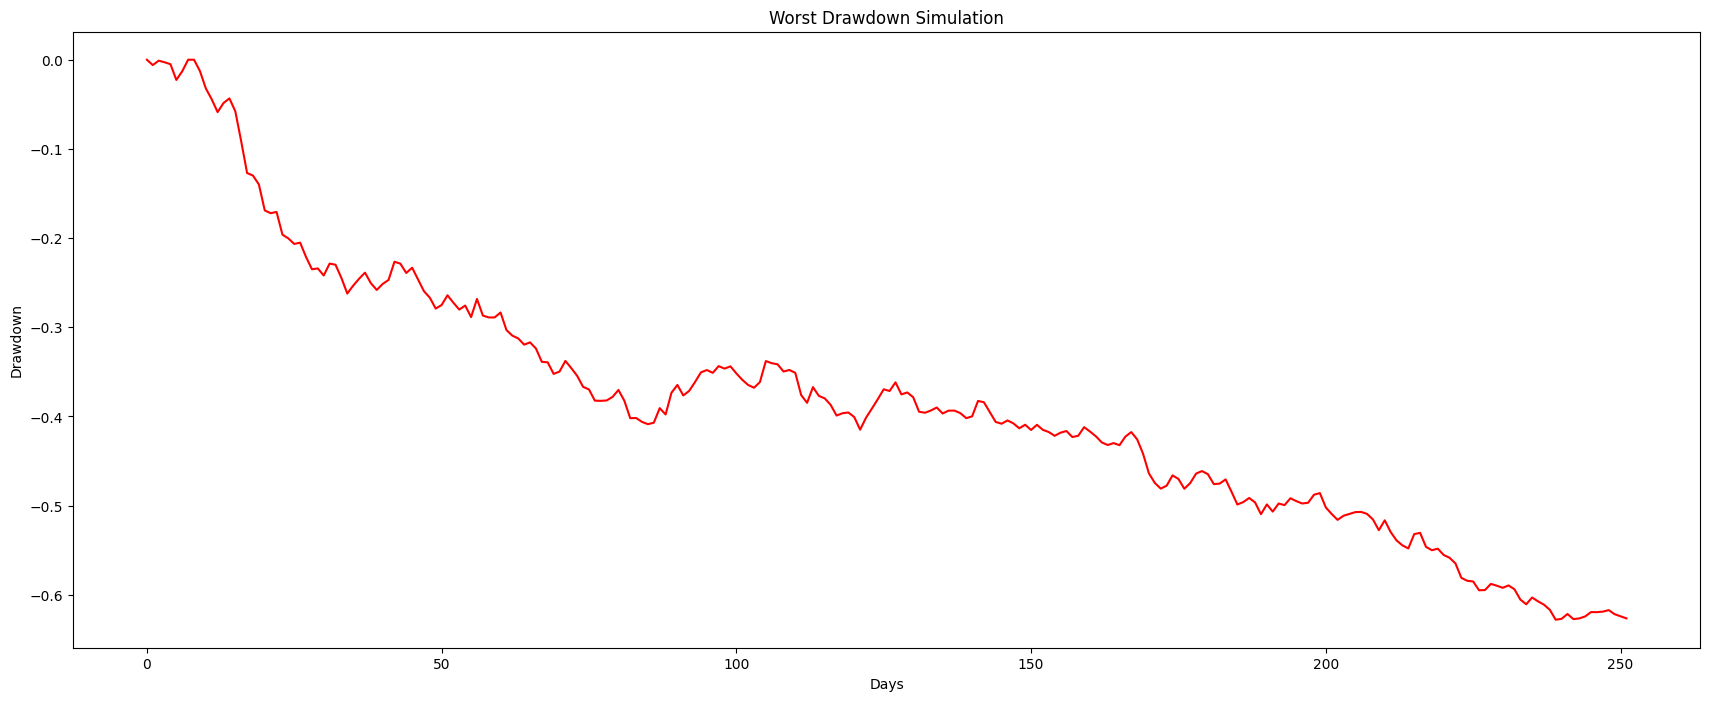

Worst Drawdown: -62.80%


In [47]:
analyse_drawdowns(portfolio_simulations)

Value at Risk (VaR) at 5% confidence level: $351,801.80
Conditional Value at Risk (CVaR) at 5% confidence level: $410,648.28
Drawdown Distribution by Percentile [1%, 5%, 50%]: [-0.49328276 -0.41749642 -0.23806271]


/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_1455/831843372.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


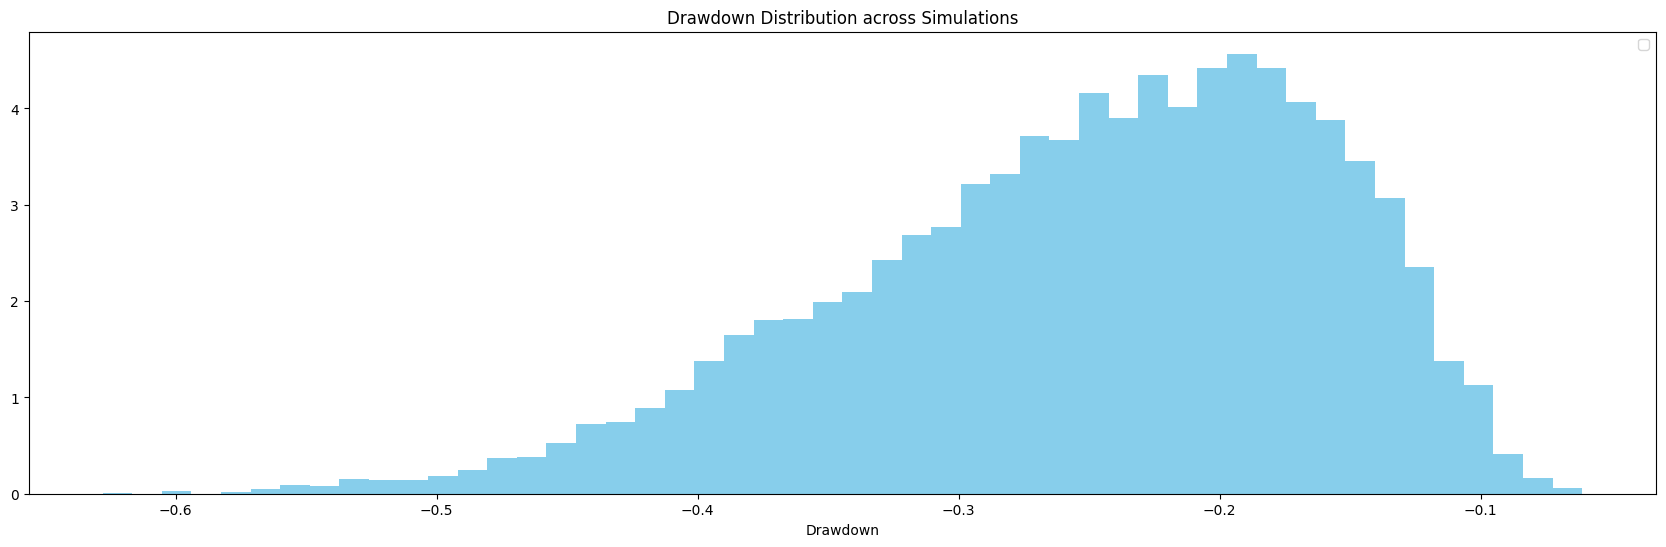

In [51]:
var, cvar = var_cvar_portfolio(portfolio_simulations, 5)
drawdown_distribution(portfolio_simulations)

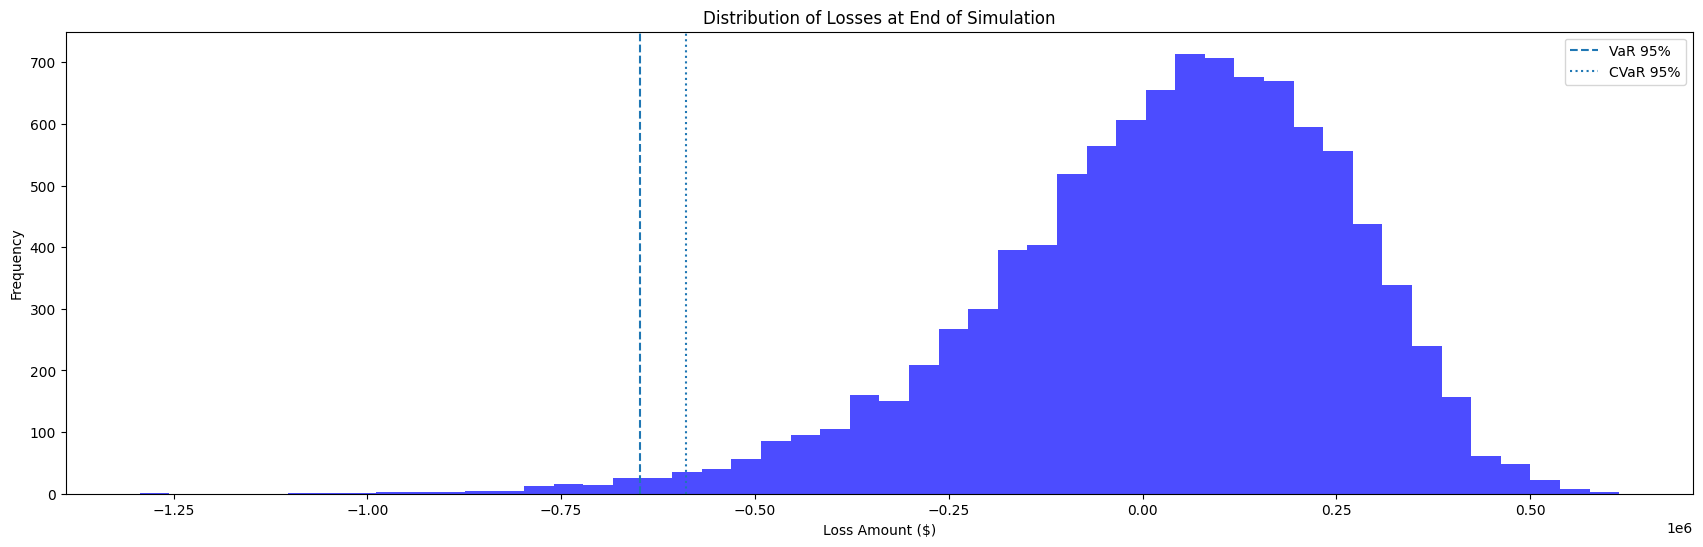

VaR(5%): $351,801.80
CVaR(5%): $410,648.28
Mean Loss: $29,367.11
Median Loss: $55,588.71


In [62]:
analyse_loss_distribution(portfolio_simulations, initial_investment, var, cvar)

### 5. **Stress Testing and Scenario Analysis**

Stress testing provides a structured framework for assessing portfolio resilience under extreme but plausible market conditions. Unlike traditional risk measures such as Value-at-Risk (VaR), which are designed to capture losses under typical market fluctuations, stress testing explicitly focuses on low-probability, high-impact events that may materially impair portfolio performance. By examining portfolio behaviour outside normal market regimes, stress testing helps identify vulnerabilities that may not be visible through standard risk metrics alone.

In this section, we develop a set of tools to construct and analyse stress scenarios using Python. We explore three complementary approaches: replicating historically observed crisis events, designing hypothetical “what-if” scenarios based on adverse market assumptions, and generating a broad distribution of outcomes through Monte Carlo simulations (which we have done above). Together, these methods provide multiple perspectives on tail risk and enhance our understanding of how portfolios may respond under severe market stress.

In summary, we aim to:
- Implement shock volatility and correlation assumptions to mimic crisis regimes
- Compare baseline and stressed portfolio risk profiles
- Interpret changes in tail risk and downside exposure

We will first define our function to model **historical scenarios**

In [102]:
def historical_scenario(ticker, start_date, end_date):
  """
  This function fetches historical data for a given ticker symbol, calculates daily returns 
  and identifies the worst single-day return and the worst return over a 250-day period (approximately one trading year).
  
  It packages these into a dictionary, making it easy to use in our stress testing framework.
  """
  data = yf.download(ticker, start=start_date, end=end_date)
  returns = data['Close'].pct_change().dropna()
  
  # Worst 250-day period in historical data
  worst_period = returns[ticker].nsmallest(250).iloc[-1]
  scenario = {
    'type': 'historical', 
    'returns': returns, 
    'worst_day': returns.min(), 
    'worst_250d': worst_period
  }
  return scenario

Next, we can define custom shocks to specific assets or risk factors as part of modelling **hypothetical scenarios**

In [90]:
def hypothetical_scenario(assets, shocks):
  """
  assets: Dictionary of asset weights
  shocks: Dictionary of hypothetical shocks in percent for each asset.
  """
  scenario = {
    'type': 'hypothetical', 
    'shocks': shocks
  }
  return scenario

We will modify the above Monte-Carlo simulation to fit the stress testing / scenario analysis section

In [91]:
def monte_carlo_scenario(num_simulations, risk_factors, covariance_matrix, means, distribution='normal'):
  """
  This function generates multiple scenarios by drawing random samples from specified probability distributions.
  """
  num_of_assets = len(risk_factors)
  
  if distribution == 'normal':
    simulated_returns = np.random.multivariate_normal(means, covariance_matrix, num_simulations)
  elif distribution == 't':
    df = 5  # degrees of freedom for t-distribution
    g = np.random.chisquare(df, num_simulations) / df
    z = np.random.normal(size=(num_simulations, num_of_assets))
    simulated_returns = means + (z.T / np.sqrt(g)).T @ np.linalg.cholesky(covariance_matrix).T
  elif distribution == 'uniform':
    simulated_returns = np.random.uniform(low=-0.1, high=0.1, size=(num_simulations, num_of_assets))
  else:
    raise ValueError("Unsupported distribution type")
  
  scenarios = []
  for i in range(num_simulations):
    scenario = {
      'type': 'monte_carlo', 
      'changes': dict(zip(risk_factors, simulated_returns[i, :]))
    }
    scenarios.append(scenario)
  return scenarios
    

Unlike the previous section, we will need to define classes to manage our collection of assets, as well as classes for each asset type, including attributes relevant to stress testing

In [79]:
class Stock:
  def __init__(self, ticker, shares, current_price=None, volatility=None):
    self.ticker = ticker
    self.shares = shares
    self.current_price = current_price
    self.volatility = volatility  # Can be estimated or fetched.

    if current_price is None:
      try:  # To fetch current price data
        data = yf.download(ticker, period="1d")
        self.current_price = data['Close'][ticker][0]
      except Exception as e:
        print(f"Could not fetch current price for {ticker}: {e}")
        self.current_price = 0  # Set to 0 if fetching fails

  def get_value(self):
    return self.shares * self.current_price


class Bond:
  def __init__(self, name, maturity_date, coupon_rate, face_value, yield_to_maturity):
    self.name = name  # Add a name attribute for bonds
    self.maturity_date = maturity_date
    self.coupon_rate = coupon_rate
    self.face_value = face_value
    self.yield_to_maturity = yield_to_maturity

  def get_value(self):  # Simplified bond valuation
    return self.face_value / (1 + self.yield_to_maturity)


class Option:
  def __init__(self, underlying_asset, strike_price, expiration_date, option_type):
    self.underlying_asset = underlying_asset
    self.strike_price = strike_price
    self.expiration_date = expiration_date
    self.option_type = option_type  # "call" or "put"
    self.value = None  # Option value will depend on pricing model

  def get_value(self):
    return self.value


class Portfolio:
  def __init__(self):
    self.assets = []
  
  def add_asset(self, asset):
    self.assets.append(asset)
    
  def get_total_value(self):
    total_value = 0
    for asset in self.assets:
      total_value += asset.get_value()
    return total_value

  def get_asset_allocation(self):
    allocation = {}
    total_value = self.get_total_value()
    for asset in self.assets:
      if hasattr(asset, 'ticker'):  # Check for ticker attribute
        allocation[asset.ticker] = asset.get_value() / total_value
      elif hasattr(asset, 'name'):  # Check for name attribute (for Bonds)
        allocation[asset.name] = asset.get_value() / total_value  # Use bond name in allocation

    return allocation

With that, we will utilise our functions from above and co-integrate it with the assets defined in the start of this notebook

In [80]:
try:
  stock_data = yf.download(tickers, period="1y")  # Download data until present
except Exception as e:  # Handle possible errors during download
  print(f"Error downloading data: {e}")

[*********************100%***********************]  10 of 10 completed


In [81]:
portfolio = Portfolio()
initial_investment = 1000000

# We assign equal dollar amounts to each stock for simplicity
for ticker in tickers:
  portfolio.add_asset(Stock(ticker, initial_investment / len(tickers)))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [84]:
def portfolio_composition(portfolio):
  # Calculate and print portfolio value and allocation.
  total_portfolio_value = portfolio.get_total_value()
  print(f"Total Portfolio Value: ${total_portfolio_value:.2f}")
  asset_allocation = portfolio.get_asset_allocation()
  print(f"Asset Allocation:\n{asset_allocation}")

  asset_names = list(asset_allocation.keys())
  allocation_percentages = list(asset_allocation.values())

  # Plot a bar chart of asset allocation
  plt.figure(figsize=(10, 6))
  plt.bar(asset_names, allocation_percentages)
  plt.xlabel('Assets')
  plt.ylabel('Allocation Percentage')
  plt.title('Portfolio Asset Allocation - Bar Chart')
  plt.show()

Total Portfolio Value: $115469002.25
Asset Allocation:
{'BNS.TO': 0.08856056616615841, 'GOOGL': 0.28569573498450995, 'XOM': 0.12161704868252124, 'NIO': 0.004109327865685486, 'KO': 0.06348457064560052, 'PEP': 0.12899999041527144, 'ARCC': 0.0174505704790385, 'IBM': 0.2704015838976626, 'AGNC': 0.010258164560654853, 'LCID': 0.009422442302897006}


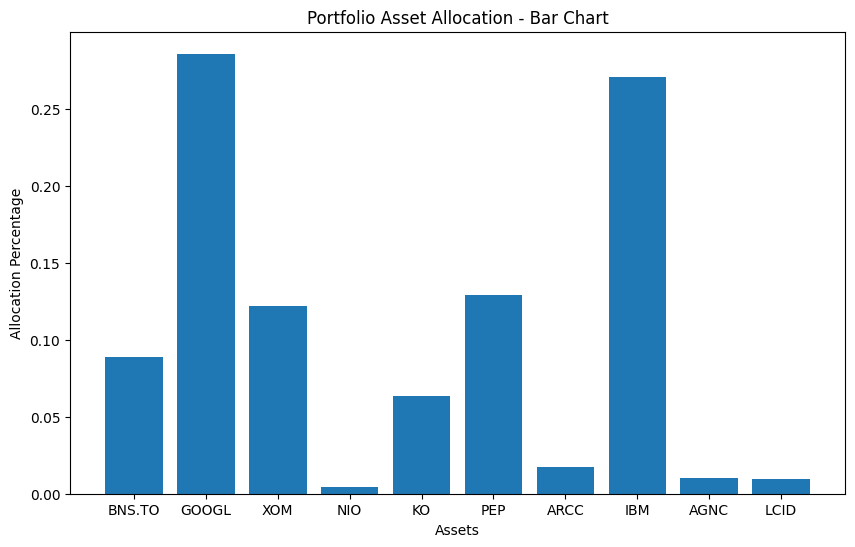

In [85]:
portfolio_composition(portfolio)

We can define a function for our sensitivity analysis

In [86]:
def sensitivity_analysis(porfolio, risk_factor, shock_range):
  """
  This function performs sensitivity analysis by shocking a specific risk factor and observing the impact on portfolio value.
  
  It takes the portfolio, a specific risk factor and a range of shocks as input. 
  It then calculates the portfolio value under each shock, providing valuable insights into the portfolio's sensitivity to that factor.
  """
  results = []
  for shock in shock_range:
    shocked_portfolio_value = 0
    for asset in porfolio.assets:
      if isinstance(asset, 'ticker') and asset.ticker == risk_factor:
        shocked_price = asset.current_price * (1 + shock / 100)
        shocked_portfolio_value += asset.shares * shocked_price
      elif hasattr(asset, 'name') and asset.name == risk_factor:
        # Example: Bond sensitivity to yield changes. Adapt if needed.
        shocked_yield = asset.yield_to_maturity + shock
        shocked_value = asset.face_value / (1+shocked_yield)
        shocked_portfolio_value += shocked_value
      else:
        shocked_portfolio_value += asset.get_value()
    results.append(shocked_portfolio_value)
  
  return shock_range, results

def portfolio_sensitivity_to_shock_visualisation(portfolio_values, risk_factor, period):
  """
  Risk factor refers to the specific asset or factor being shocked. E.g SPY
  This function visualizes the portfolio sensitivity to shocks in a specific risk factor.
  """
  risk_factor_data = yf.download(risk_factor, period=period)  # Download more data than before
  risk_factor_returns = risk_factor_data['Close'].pct_change().dropna()
  
  # Calculate the VaR and CVaR for the risk factor
  risk_factor_var = calculate_var(risk_factor_returns, 5)
  risk_factor_cvar = calculate_cvar(risk_factor_returns, 5)
  print(f"Risk Factor ({risk_factor}) VaR(5%): {risk_factor_var:.4f}")
  print(f"Risk Factor ({risk_factor}) CVaR(5%): {risk_factor_cvar:.4f}")
  
  shock_range = np.linspace(-0.2, 0.2, 200)  # -10% to +10%
  shocks, portfolio_values = sensitivity_analysis(portfolio, risk_factor, shock_range)
  
  plt.figure(figsize=(21, 6))
  plt.plot(shocks, portfolio_values, marker='o')
  plt.title(f'Portfolio Sensitivity to {risk_factor} Shocks')
  plt.xlabel('Shock (%)')
  plt.ylabel('Portfolio Value ($)')
  plt.grid()
  plt.show()

Now, we will create a function to simulate portfolio performance under stress

In [92]:
def backtest_portfolio(portfolio, scenario):
  """
  This function backtests the portfolio against a given scenario.
  It adjusts the asset values based on the scenario's shocks or historical returns,
  and calculates the portfolio value after applying the scenario.
  """
  portfolio_value = portfolio.get_total_value()
  
  if scenario['type'] == 'historical':
    returns = scenario['returns']
    # Example: Apply historical returns to the SPY portion of the portfolio
    shocked_portfolio_value = 0
    for asset in portfolio.assets:
      if hasattr(asset, 'ticker') and asset.ticker == 'SPY':  # Example, adapt if needed
        # Use the last return from the historical scenario
        shocked_value = asset.get_value() * (1 + returns.iloc[-1])
        shocked_portfolio_value += shocked_value
      else:
        shocked_portfolio_value += asset.get_value()
    portfolio_return = (shocked_portfolio_value - portfolio_value) / portfolio_value
  
  elif scenario['type'] == 'hypothetical':
    shocked_portfolio_value = 0
    for asset in portfolio.assets:
      if hasattr(asset, 'ticker') and asset.ticker in scenario['shocks']:
        shocked_price = asset.current_price * (1 + scenario['shocks'][asset.ticker])
        shocked_portfolio_value += shocked_price * asset.shares
      else:
        shocked_portfolio_value += asset.get_value()
    portfolio_return = (shocked_portfolio_value / portfolio_value) - 1
  
  elif scenario['type'] == 'monte_carlo':
    shocked_portfolio_value = 0
    for asset in portfolio.assets:
      if hasattr(asset, 'ticker') and asset.ticker in scenario['changes']:
        shocked_price = asset.current_price * (1 + scenario['changes'][asset.ticker])
        shocked_portfolio_value += shocked_price * asset.shares
      else:
        shocked_portfolio_value += asset.get_value()
    portfolio_return = (shocked_portfolio_value - portfolio_value) / portfolio_value
  
  return portfolio_return


def generate_scenario(scenario_type, **kwargs):
  if scenario_type == 'historical':
    return historical_scenario(**kwargs)
  elif scenario_type == 'hypothetical':
    return hypothetical_scenario(**kwargs)
  elif scenario_type == 'monte_carlo':
    return monte_carlo_scenario(**kwargs)
  else:
    raise ValueError("Unsupported scenario type")


def backtesting_visualisation(num_simulations, shock_factor, risk_factors, asset_weights, shocks, start_date, end_date, covariance_matrix, means):
  # Historical Scenario
  hist_scenario = generate_scenario('historical', ticker=shock_factor, start_date=start_date, end_date=end_date)
  
  # Hypothetical Scenario
  hypo_scenario = generate_scenario('hypothetical', assets=asset_weights, shocks=shocks)

  # Monte Carlo Scenario
  mc_scenarios = generate_scenario('monte_carlo', num_simulations=num_simulations, risk_factors=risk_factors, covariance_matrix=covariance_matrix, means=means)
  
  portfolio_returns_hist = [backtest_portfolio(portfolio, hist_scenario) for _ in range(250)]  # example number of points, using same scenario
  portfolio_returns_hypo = backtest_portfolio(portfolio, hypo_scenario)
  portfolio_returns_mc = [backtest_portfolio(portfolio, s) for s in mc_scenarios]
  
  shock_factor_changes = [scenario['changes'][shock_factor] for scenario in mc_scenarios]
  
  # Visualization
  plt.figure(figsize=(10, 6))
  plt.hist(portfolio_returns_mc, bins=50)
  plt.title('Distribution of Portfolio Returns (Monte Carlo)')
  plt.xlabel('Portfolio Return')
  plt.ylabel('Frequency')
  plt.show()

  plt.figure(figsize=(10, 6))
  # Example using SPY changes from previous sections
  plt.scatter(shock_factor_changes, portfolio_returns_mc)
  plt.title(f'Portfolio Returns vs. {shock_factor} Changes (Monte Carlo)')
  plt.xlabel(f'{shock_factor} Change')
  plt.ylabel('Portfolio Return')
  plt.show()


  plt.figure(figsize=(10, 6))
  plt.boxplot([portfolio_returns_hist, portfolio_returns_mc],
              labels=['Historical', 'Monte Carlo'])
  plt.title('Portfolio Returns: Historical vs. Monte Carlo')
  plt.ylabel('Portfolio Return')
  plt.show()

  # Example print, showing only one
  print(f"Portfolio Return (Historical): {portfolio_returns_hist[0]:.4f}")
  print(f"Portfolio Return (Hypothetical): {portfolio_returns_hypo:.4f}")
  print(f"Example Portfolio Return (Monte Carlo): {portfolio_returns_mc[0]:.4f}")
  

[*********************100%***********************]  1 of 1 completed


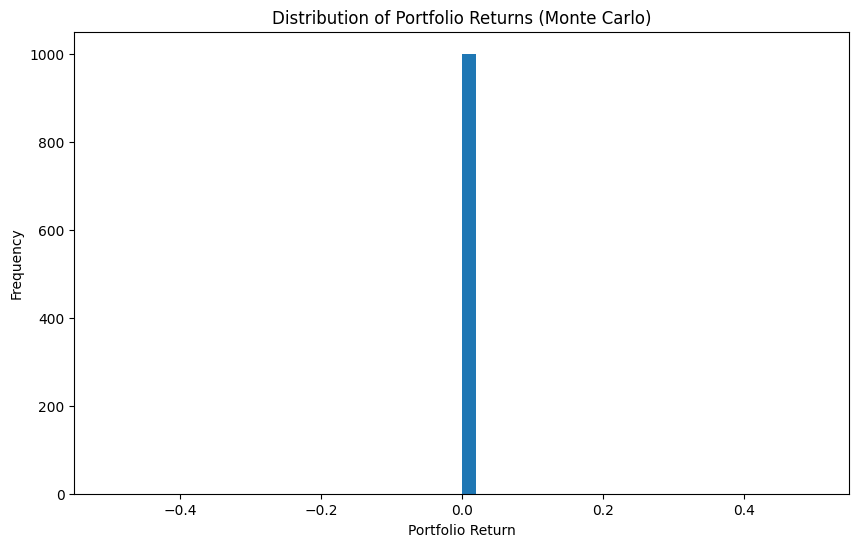

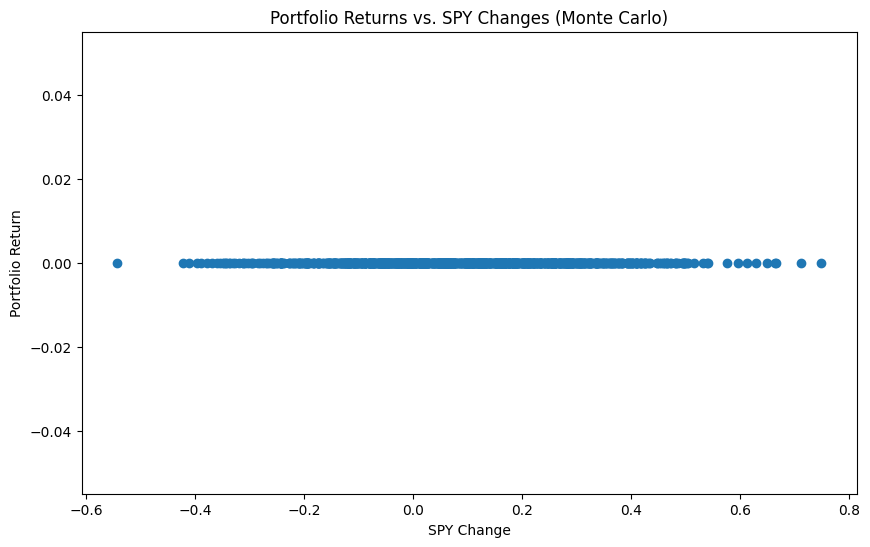

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_1455/1253174395.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([portfolio_returns_hist, portfolio_returns_mc],


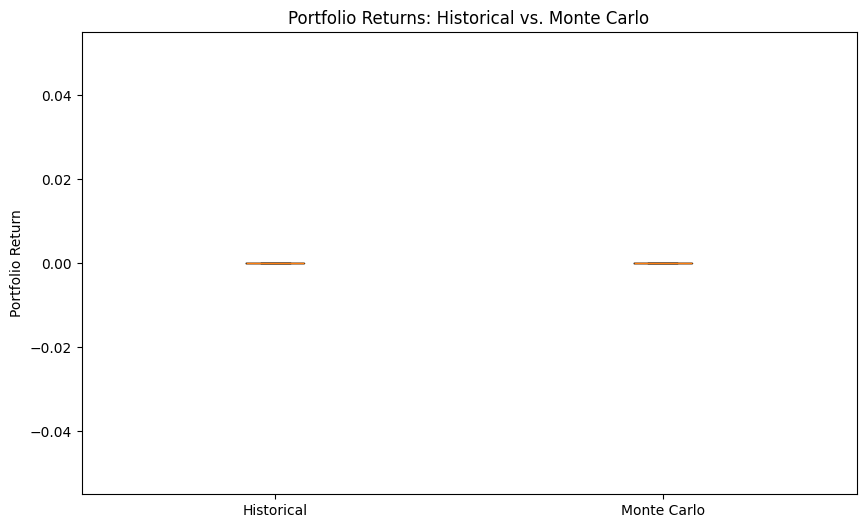

Portfolio Return (Historical): 0.0000
Portfolio Return (Hypothetical): 0.0000
Example Portfolio Return (Monte Carlo): 0.0000


In [103]:
num_of_simulations = 1000
shock_factor = 'SPY'
asset_weights = {'SPY': 0.6, 'AGG': 0.4}
shocks = {'SPY': -0.3, 'AGG': -0.1}  # 30% drop in SPY, 10% drop in AGG
risk_factors = ['SPY', 'AGG', 'GLD']  # Example risk factors

# Example correlation matrix. Must be positive-semidefinite.
correlation_matrix = np.array([[1, 0.2, -0.1], [0.2, 1, 0.05], [-0.1, 0.05, 1]])
volatilities = [0.2, 0.1, 0.15]  # Annual volatilities of each factor
means = [0.1, 0.05, 0.03]      # Annual returns of each factor
covariance_matrix = np.array(correlation_matrix) * np.outer(volatilities, volatilities)

backtesting_visualisation(num_of_simulations, shock_factor, risk_factors, asset_weights, shocks, start_date, end_date, covariance_matrix, means)